In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

In [ ]:
# Download dataset
# The folder will be called data_v1
# https://drive.google.com/file/d/1OHUbWckqcwxHdG0azvbZUffm5H37v04J/view?usp=sharing
# https://drive.google.com/file/d/1JqC15wvkm34cUGlPpz8gnRxRdpU1s1tX/view?usp=drive_link
# !wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1JqC15wvkm34cUGlPpz8gnRxRdpU1s1tX" -O augmented_augmented_data.zip
!unzip -q /content/augmented_cropped_data2_12101357.zip -d /content/

In [ ]:
len(os.listdir("/content/content/augmented_cropped_data2_12101357"))

71265

In [ ]:
# Sort data into labeled folders, then create and train and test split

import os
import shutil
from sklearn.model_selection import train_test_split

# Define directories
dataset_dir = '/content/content/augmented_cropped_data2_12101357'  # Path to your dataset


## Sort data into folders labeled by note

# Iterate through all note labels (e.g., A4, C5, etc.)
POSSIBLE_NOTES = [
        "A3",
        "B3",
        "C4",
        "D4",
        "E4",
        "F4",
        "G4",
        "A4",
        "B4",
        "C5",
        "D5",
        "E5",
        "F5",
        "G5",
        "A5",
        "B5",
        "C6",
    ]

# Get a list of all images in the dataset directory
all_images = [f for f in os.listdir(dataset_dir) if f.lower().endswith('png')]

# Iterate through all the possible labels
for label in POSSIBLE_NOTES:

    # Create a subdirectory for each label inside the dataset directory
    label_dir = os.path.join(dataset_dir, label)
    os.makedirs(label_dir, exist_ok=True)

    # Filter the images that contain the current label in their filename
    label_images = [img for img in all_images if label in img]

    # Move the images to their respective label folder
    for img in label_images:
        shutil.move(os.path.join(dataset_dir, img), os.path.join(label_dir, img))




## Sort data into a train and test set

# Define directories
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Create directories for train and test sets if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate through all the possible labels
for label in POSSIBLE_NOTES:
    # Path to the label directory
    label_dir = os.path.join(dataset_dir, label)

    # Get a list of all images for the current label
    label_images = [f for f in os.listdir(label_dir) if f.lower().endswith('png')]

    # Split the images into train and test sets using train_test_split
    train_images, test_images = train_test_split(label_images, test_size=0.2, random_state=42)

    # Create subdirectories for this label under both train and test
    label_train_dir = os.path.join(train_dir, label)
    label_test_dir = os.path.join(test_dir, label)
    os.makedirs(label_train_dir, exist_ok=True)
    os.makedirs(label_test_dir, exist_ok=True)

    # Move the images to their respective directories
    for img in train_images:
        shutil.move(os.path.join(label_dir, img), os.path.join(label_train_dir, img))

    for img in test_images:
        shutil.move(os.path.join(label_dir, img), os.path.join(label_test_dir, img))

# Remove empty directories from the original dataset
for label in POSSIBLE_NOTES:
    label_dir = os.path.join(dataset_dir, label)
    if not os.listdir(label_dir):  # If the directory is empty
        os.rmdir(label_dir)  # Remove the empty directory


In [ ]:
# Define image transformations for data augmentation
IMAGE_SIZE = 56  # Desired size for the square images

resize = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE), antialias=True),  # Resize to 32x32
])

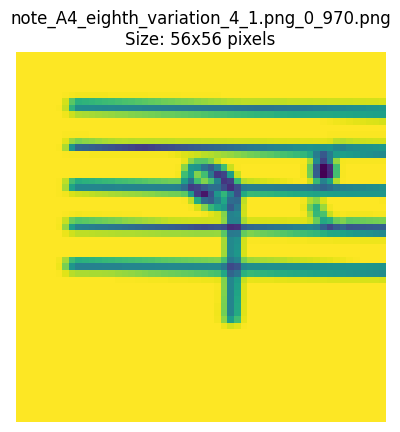

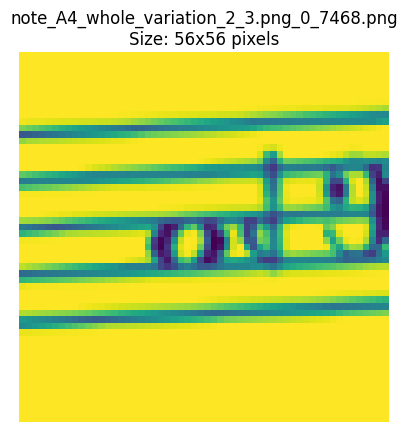

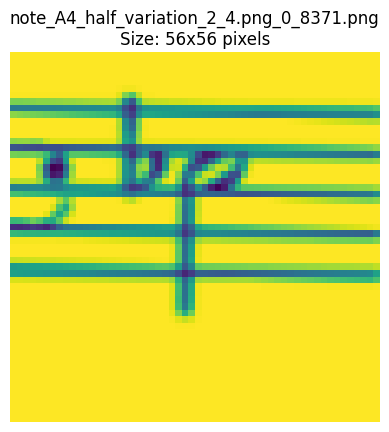

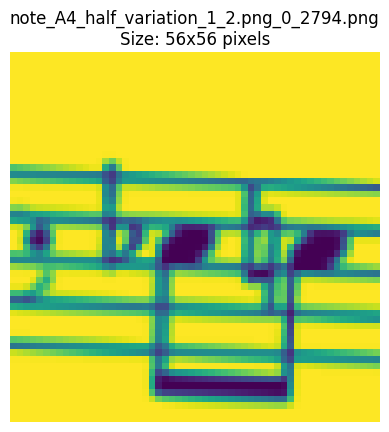

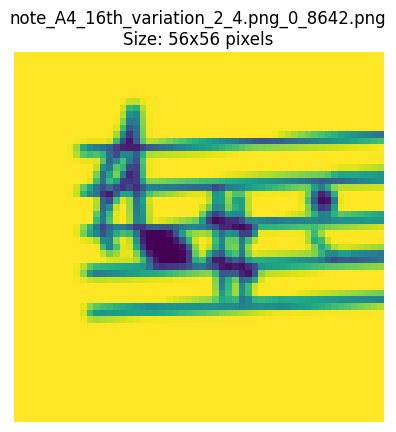

In [ ]:
# View some of the data

from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os


# Directory containing your images
image_dir =  '/content/content/augmented_cropped_data2_12101357/train/A4'  # Path to your dataset


# List the files in the directory
images = [f for f in os.listdir(image_dir) if f.endswith('.png')]


# Display some images and their sizes
for i, img_name in enumerate(images[:5]):  # Limit to first 5 images
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)

    # Perform image transforms
    img = resize(img)

    # Get width and height
    width, height = img.size

    # Display the image
    plt.figure()
    plt.imshow(img)
    plt.axis('off')  # Turn off axes
    plt.title(f"{img_name}\nSize: {width}x{height} pixels")
    plt.show()

In [ ]:
# Configuration
DATA_DIR = "/content/content/augmented_cropped_data2_12101357"  # Path to the dataset
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

# Data Preparation
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE), antialias=True),  # Resize to 56x56
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if not already
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "train"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# CNN Model
class PitchClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PitchClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), # 32 * 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #  32 * 32 -> 16 * 16

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8 * 8

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 4 * 4
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7* 7, 128), # channels of last output layer * output dimensions, basically number of output parameters from convolutions
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize Model
num_classes = len(train_dataset.classes)  # Automatically detect the number of classes
model = PitchClassifier(num_classes)

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_losses = []
test_losses = []
accuracies = []

# Training Loop
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            # Metrics
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

        train_accuracy = correct / len(train_loader.dataset)
        test_accuracy, test_loss = evaluate_model(model, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Accuracy: {test_accuracy:.4f}")


def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct, test_loss = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return correct / len(test_loader.dataset), test_loss / len(test_loader)  # Average test loss per batch

# Start Training
train_model(model, train_loader, test_loader, criterion, optimizer, EPOCHS)


NameError: name 'IMAGE_SIZE' is not defined

In [ ]:
# Save the model's weights
torch.save(model.state_dict(), "pitch_classifier.pth")

NameError: name 'torch' is not defined

In [ ]:
# Plot a graph of the loss - Not working
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(EPOCHS), train_losses, label='training cross-entropy')
plt.plot(range(EPOCHS), test_losses, label='testing cross-entropy')
plt.xlabel('step')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(EPOCHS), accuracies)
plt.xlabel('step')
plt.ylabel('accuarcy')
plt.show()

NameError: name 'EPOCHS' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
!zip -r /content/data_length_final.zip /content/augmented_cropped_data/
from google.colab import files
files.download("/content/data_length_final.zip")

Streaming output truncated to the last 5000 lines.
  adding: content/augmented_cropped_data/train/E4/note_E4_16th_variation_4_0_0_6297.png (stored 0%)
  adding: content/augmented_cropped_data/train/E4/note_E4_quarter_variation_2_3_0_9529.png (stored 0%)
  adding: content/augmented_cropped_data/train/E4/note_E4_quarter_variation_2_0_0_1418.png (stored 0%)
  adding: content/augmented_cropped_data/train/E4/note_E4_half_variation_0_3_0_7087.png (stored 0%)
  adding: content/augmented_cropped_data/train/E4/note_E4_16th_variation_3_3_0_7815.png (stored 0%)
  adding: content/augmented_cropped_data/train/E4/note_E4_quarter_variation_0_4_0_968.png (stored 0%)
  adding: content/augmented_cropped_data/train/E4/note_E4_whole_variation_0_2_0_922.png (stored 0%)
  adding: content/augmented_cropped_data/train/E4/note_E4_half_variation_0_2_0_7803.png (stored 0%)
  adding: content/augmented_cropped_data/train/E4/note_E4_quarter_variation_0_3_0_3294.png (stored 0%)
  adding: content/augmented_cropped_da

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch

class PitchClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PitchClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), # 32 * 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #  32 * 32 -> 16 * 16

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8 * 8

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 4 * 4
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7* 7, 128), # channels of last output layer * output dimensions, basically number of output parameters from convolutions
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x